## Convergence-breaking study 
Here we characterize the convergence breaking of BP and rs-cavity method on the nishimori line

In [11]:
import OffsetArrays
using Plots
using Revise
using StatsBase
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
using Distributions
srcpath = "../src"
include("$srcpath/single_instance.jl")
include("$srcpath/bp.jl")
include("$srcpath/post_infer.jl")
include("$srcpath/observables.jl")

avg_ninf (generic function with 1 method)

First we characterize the number of connected components in which a patient zero can be placed in the inference process. We see that this number increases a lot around 0.01

In [39]:
T = 8
λp = 1.0
Ngraph = 50000 # size of the single instance graph
N = Ngraph
x = zeros(Int,Ngraph, T + 1) # a single epidemic trajectory
degree_dist = Dirac(3)
G = makeGraph(Ngraph,degree_dist)
γRange = LinRange(0.001,0.025,100) 
n_zp = zeros(100)
@showprogress for st = 1:100
    sample!(x, G, λp, γRange[st])
    n_zp[st] = possible_zero_patients(G,x)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


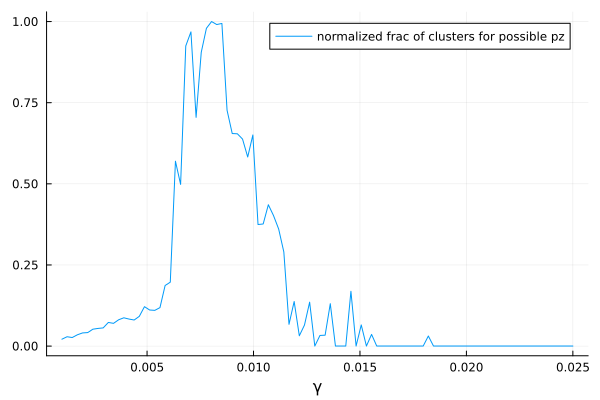

In [62]:
γRange = LinRange(0.001,0.025,100) 
plot(γRange,n_zp ./ maximum(n_zp),xlabel="γ",label="normalized frac of clusters for possible pz")

We now study convergence of the Epidemle algorithm.

In [45]:
N = 5000
γRange = LinRange(0.01,0.05,25)
iter_ensemble = zeros(length(γRange))
Threads.@threads for st = 1:length(γRange)
    γi = γp = γRange[st]
    M = ParametricModel(N = N, T = T, γp = γp, λp = λp, γi=γi, distribution=degree_dist) ;
    F,it = pop_dynamics(M, tot_iterations = 30);
    iter_ensemble[st] = it
end

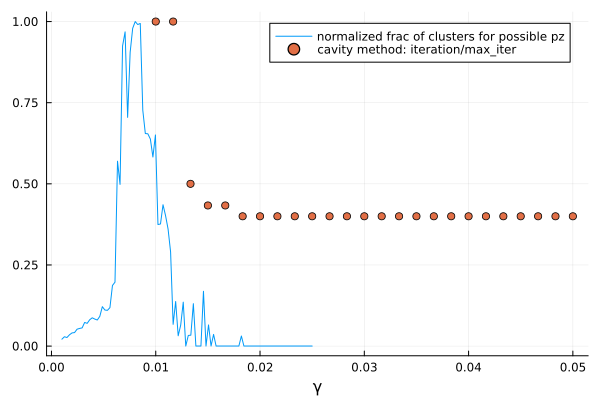

In [63]:
γRange = LinRange(0.01,0.05,25)
scatter!(γRange,iter_ensemble./maximum(iter_ensemble),label="cavity method: iteration/max_iter")

Now we study Belief propagation convergence

In [61]:
Ngraph = 4000
x = zeros(Int,Ngraph, T + 1) 
tol = 1e-2
maxit = 100
γRange = LinRange(0.005,0.05,25)
tot_iters = zeros(length(γRange))
totsamp = 1
for st in 1:length(γRange)
    for samp = 1:totsamp
        # for every iteration we initialize a new graph
        G = makeGraph(Ngraph,degree_dist)
        γi = γp = γRange[st] 
        # we sample an epidemic
        sample!(x, G, λp, γp)
        O = [(i,Bool(x[i,T+1]),T+1,1e-10) for i = 1:Ngraph]
        function saveiters(t,err,f)
            if err < tol || t == maxit-1
                tot_iters[st] += t 
            end
        end
        #we now run the BP algorithm for the single instance defined above
        sibyl(Ngraph, T+1, G, O,  γi , 1.0; maxit = maxit, tol = tol, callback=saveiters);
    end
end
tot_iters ./= totst;

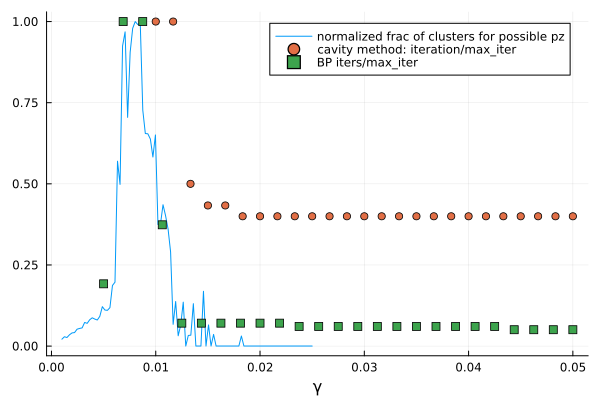

In [64]:
γRange = LinRange(0.005,0.05,25)
scatter!(γRange,tot_iters./maximum(tot_iters),marker=:square,label="BP iters/max_iter")